In [12]:
import os
import subprocess

java_home = subprocess.check_output(["/usr/libexec/java_home", "-v", "17"]).strip().decode('utf-8')

# Set JAVA_HOME and PATH
os.environ["JAVA_HOME"] = java_home
os.environ["PATH"] = os.path.join(java_home, "bin") + ":" + os.environ["PATH"]
os.environ["PYSPARK_SUBMIT_ARGS"] = "--master local pyspark-shell"

# Verify JAVA_HOME and Java version
print("JAVA_HOME:", os.environ['JAVA_HOME'])
!java -version

JAVA_HOME: /Library/Java/JavaVirtualMachines/jdk-17.jdk/Contents/Home
java version "17.0.8" 2023-07-18 LTS
Java(TM) SE Runtime Environment (build 17.0.8+9-LTS-211)
Java HotSpot(TM) 64-Bit Server VM (build 17.0.8+9-LTS-211, mixed mode, sharing)


In [13]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Logistic_Regression") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.instances", "4") \
    .getOrCreate()

In [14]:
file_path = "output/processedv3.parquet"
df = spark.read.parquet(file_path)

In [15]:
df.show(5)
df.printSchema()

+-------+--------+--------+-------+------+--------+--------+--------+--------+-------+--------+--------+--------+-----+--------+--------+--------+--------+--------+---+
|GENHLTH|_AGEG5YR|_RFHYPE6|EMPLOY1|_MICHD|_DRDXAR2|_HCVU653|_RFCHOL3|METVL12_|ALCDAY4|_BMI5CAT|DIFFWALK|_TOTINDA|EDUCA|_INCOMG1|CHCKDNY2|FALL12MN|SMOKE100|CVDINFR4|  y|
+-------+--------+--------+-------+------+--------+--------+--------+--------+-------+--------+--------+--------+-----+--------+--------+--------+--------+--------+---+
|    2.0|     9.0|     1.0|    2.0|   2.0|     2.0|     1.0|     2.0|   106.0|  220.0|     2.0|     2.0|     1.0|  6.0|     5.0|     2.0|     2.0|     2.0|     2.0|  0|
|    3.0|     8.0|     1.0|    1.0|   2.0|     2.0|     1.0|     1.0|   104.0|  210.0|     4.0|     2.0|     1.0|  6.0|     5.0|     2.0|    88.0|     2.0|     2.0|  0|
|    3.0|     7.0|     2.0|    1.0|   2.0|     2.0|     1.0|     2.0|   103.0|  888.0|     4.0|     1.0|     1.0|  4.0|     2.0|     2.0|    88.0|     1.0|

In [16]:
num_columns = len(df.columns)
num_rows = df.count()
# Print the dimensions
print(f"Dimensions of DataFrame: {num_rows} rows, {num_columns} columns")

Dimensions of DataFrame: 95574 rows, 20 columns


In [17]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Combine feature columns into a single vector column
feature_cols = df.columns
feature_cols.remove("y")

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(df)

# Split the data
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Create LogisticRegression model
lr = LogisticRegression(featuresCol="features", labelCol="y")

# Create ParamGrid for Cross Validation
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.3]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [10, 20, 30]) \
    .build()

# Create evaluator
evaluator = BinaryClassificationEvaluator(labelCol="y")

# Create CrossValidator
cv = CrossValidator(estimator=lr,
                   estimatorParamMaps=paramGrid,
                   evaluator=evaluator,
                   numFolds=5,
                   seed=42)
                   

In [18]:
# Fit the model
cv_model = cv.fit(train_data)

# Make predictions on test data
predictions = cv_model.transform(test_data)

In [19]:
# Evaluate the model
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")

# Get the best model parameters
best_model = cv_model.bestModel
print("Best Model Parameters:")
print(f"RegParam: {best_model.getRegParam()}")
print(f"ElasticNetParam: {best_model.getElasticNetParam()}")
print(f"MaxIter: {best_model.getMaxIter()}")

AUC: 0.8000791513594122
Best Model Parameters:
RegParam: 0.01
ElasticNetParam: 0.0
MaxIter: 10


In [20]:
predictions.select("y", "probability", "prediction", "features").show(5)

+---+--------------------+----------+--------------------+
|  y|         probability|prediction|            features|
+---+--------------------+----------+--------------------+
|  0|[0.97842701880622...|       0.0|[1.0,6.0,1.0,1.0,...|
|  0|[0.95865816786460...|       0.0|[1.0,6.0,1.0,1.0,...|
|  0|[0.98223183069409...|       0.0|[1.0,6.0,1.0,1.0,...|
|  0|[0.94030032986410...|       0.0|[1.0,6.0,1.0,1.0,...|
|  0|[0.98872182512644...|       0.0|[1.0,6.0,1.0,1.0,...|
+---+--------------------+----------+--------------------+
only showing top 5 rows



In [21]:
# Calculate the confusion matrix
true_negative = predictions.filter("y=0").filter("prediction=0").count()
print(f"True Negative count: {true_negative}")
false_positive = predictions.filter("y=0").filter("prediction=1").count()
print(f"False Positive count: {false_positive}")
false_negative = predictions.filter("y=1").filter("prediction=0").count()
print(f"False Negative count: {false_negative}")
true_positive = predictions.filter("y=1").filter("prediction=1").count()
print(f"True Positive count: {true_positive}")

# Calculate the Precision & Recall
precision = true_positive/(true_positive+false_positive)
print(f"Precision: {precision}")
recall = true_positive/(true_positive+false_negative)
print(f"Recall: {recall}")

True Negative count: 15899
False Positive count: 382
False Negative count: 2485
True Positive count: 470
Precision: 0.5516431924882629
Recall: 0.15905245346869712


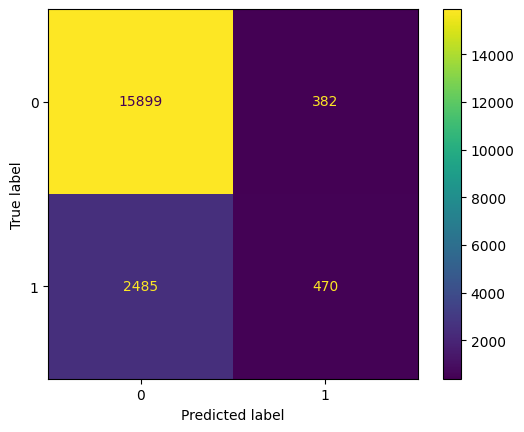

In [22]:
#Plot the confusion matrix
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

actual = np.array(test_data.select("y").collect())
predicted = predictions.withColumn("prediction", predictions["prediction"].cast(IntegerType()))
predicted = np.array(predicted.select("prediction").collect())

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()